In [1]:
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate
import math


In [2]:
opinions = pd.read_csv('csv_data/preprocesed_files/anomaly_opinions.csv')
# Tworzenie listy krotek
opinions_list = [(row['content'], row['doubleQuality']) for _, row in opinions.iterrows()]
random.shuffle(opinions_list)


In [3]:
# opinions_list=opinions_list[0:3000]
sum_of_values = sum(item[1] for item in opinions_list)
print(sum_of_values)  #

107


In [4]:
nlp = spacy.load('pl_core_news_md')

# Obiekt PhraseMatcher
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

# Lista fraz
term_list = ["lepszy niż", "lepszy od", "nie ma już", "na rynku", "w polskich", "lepszej jakosci", "od niemca", "nad polskimi",
             "tak dobrze jak", "jak niemiecki", "polskiej wersji", "nad polskimi", "jak niemiecki", "najlepszy bo", "polski produkt",
             "niemieckie wydanie", "jest Niemieckim", "oryginalne niemieckie", "z niemiec", "to niemiecki", "niemiecka chemia",
             "niemiecka jakość", "oryginalny produkt", "rynek zachodni", "lepsza niż", "rynek polski", "zachodni rynek",
             "niemiecki rynek", "jak polski", "wyprodukowany w", "produkowany w niemczech", "nie dorównują", "polskiej wersji", "europę wschodnią"]
print(len(term_list))
term_list = list(set(term_list))
print(len(term_list))


34
31


In [5]:

columns = 4
rows = math.ceil(len(term_list) / columns)
table = []

for i in range(rows):
    row = term_list[i*columns:(i+1)*columns]
    table.append(row)

print(tabulate(table,  tablefmt="fancy_grid"))

╒═══════════════════════╤═════════════════════════╤════════════════════╤═════════════════╕
│ lepsza niż            │ w polskich              │ niemiecki rynek    │ jak niemiecki   │
├───────────────────────┼─────────────────────────┼────────────────────┼─────────────────┤
│ wyprodukowany w       │ to niemiecki            │ lepszy niż         │ nie dorównują   │
├───────────────────────┼─────────────────────────┼────────────────────┼─────────────────┤
│ na rynku              │ oryginalny produkt      │ niemieckie wydanie │ rynek zachodni  │
├───────────────────────┼─────────────────────────┼────────────────────┼─────────────────┤
│ niemiecka jakość      │ lepszej jakosci         │ jak polski         │ jest Niemieckim │
├───────────────────────┼─────────────────────────┼────────────────────┼─────────────────┤
│ oryginalne niemieckie │ niemiecka chemia        │ polskiej wersji    │ nie ma już      │
├───────────────────────┼─────────────────────────┼────────────────────┼─────────────────┤

In [21]:

def rule_based_double_quality_search(dataset, term_list):

    total_sentences = len(dataset)
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    # Konwersja fraz na obiekty typu Document
    patterns = [nlp.make_doc(t) for t in term_list]

    # Dodanie wzorców do obiektu matcher
    matcher.add("Phrase Match", None, *patterns)

    for txt in dataset:
        # Tekst wejściowy jako obiekt typu Document
        doc = nlp(txt[0])
        
        # Wywołanie metody matcher na obiekcie doc. Zwraca obiekty typu Span
        matches = matcher(doc, as_spans=True)
        
        if len(matches) > 0:
            if(txt[1] == 1):
                true_positives += 1
            else:
                false_positives += 1
        else:            
            if(txt[1] == 0):
                true_negatives += 1
            else:
                false_negatives += 1
    
    # Tworzenie listy z danymi
    data = [
        ["Liczba zdań ze zbioru:", total_sentences],
        ["TP:", true_positives],
        ["FN:", false_negatives],
        ["FP:", false_positives],
        ["TN:", true_negatives]
    ]

    # Obliczenie metryk
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    loss = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Dodanie metryk do listy danych
    data.extend([
        ["Miary:"],
        ["Precision (precyzja):", precision],
        ["Recall (czułość):", recall],
        ["Accuracy (dokładność):", accuracy],
        ["Loss (strata):", loss],
        ["F1 Score (miara F1):", f1_score]
    ])

    # Wypisanie danych w postaci tabeli
    print(tabulate(data, headers=["Miary","Wartości"], tablefmt="fancy_grid"))

    confusion_matrix = [[true_positives, false_negatives], [false_positives, true_negatives]]

   # Tworzenie etykiet dla macierzy pomyłek
    labels = [["Pozytywna", "Negatywna"], ["Pozytywna", "Negatywna"]]

    # Wykreślenie Confusion Matrix z etykietami
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels[0], yticklabels=labels[1])
    plt.xlabel("Klasa predykowana")
    plt.ylabel("Klasa rzeczywista")
    plt.title("Tablica pomyłek")
    plt.show()


╒════════════════════════╤════════════╕
│ Miary                  │   Wartości │
╞════════════════════════╪════════════╡
│ Liczba zdań ze zbioru: │ 107        │
├────────────────────────┼────────────┤
│ TP:                    │  52        │
├────────────────────────┼────────────┤
│ FN:                    │  55        │
├────────────────────────┼────────────┤
│ FP:                    │   0        │
├────────────────────────┼────────────┤
│ TN:                    │   0        │
├────────────────────────┼────────────┤
│ Miary:                 │            │
├────────────────────────┼────────────┤
│ Precision (precyzja):  │   1        │
├────────────────────────┼────────────┤
│ Recall (czułość):      │   0.485981 │
├────────────────────────┼────────────┤
│ Accuracy (dokładność): │   0.485981 │
├────────────────────────┼────────────┤
│ Loss (strata):         │   0.514019 │
├────────────────────────┼────────────┤
│ F1 Score (miara F1):   │   0.654088 │
╘════════════════════════╧════════════╛


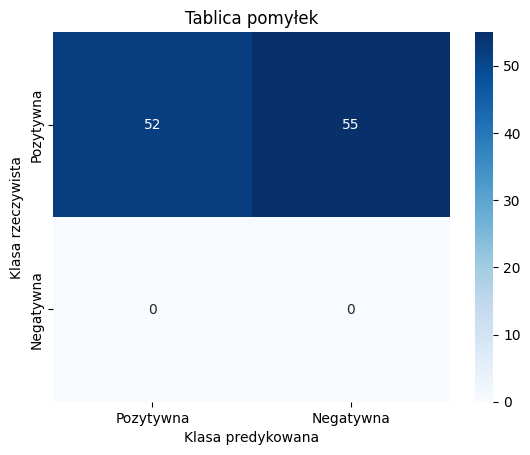

In [22]:
# Oblicz miary dla zbioru anomaly_opinions
rule_based_double_quality_search(opinions_list, term_list)